### A dirty little trick to avoid having to deal with the notion of relative path. 

In [90]:
import os
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [91]:
os.getcwd()

'/home/juagudelo/HOMEdev/drought_pred_hybrid'

## From here, this notebook is going to be used to evaluate the best model issued from the hyperparameter tuning over the test set.

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import models
import utilities

In [93]:
# Fixing a seed to warrant the reproducibility
torch.manual_seed(21)
np.random.seed(21)

In [94]:
# Initializing the model
num_categorical_features=7
num_numerical_features=22
num_time_series_features=21
batch_size=128
output_weeks=6
# Hyperparameters
hidden_size = 340
num_lstm_layers = 8
embedding_dims = 270
num_fc_tabular_layers= 4
num_fc_combined_layers= 1
dropout= 0.3

In [95]:
# Importing the list of unique categories for the categorical features
with open(f"data/processed_dataFrames/list_cat.pickle", "rb") as f:
    list_cat = pickle.load(f)

In [96]:
# Setting up the loaders
dfs=utilities.load_dataFrames()
valid_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_valid"],
                                         X_static_cat=dfs["X_tabular_cat_valid"],
                                         X_time=dfs["X_time_valid"],
                                         y_target=dfs["y_target_valid"],
                                         output_weeks=output_weeks,
                                         y_past=None,
                                         batch_size=128,
                                         shuffle=False
                                         )
test_loader=utilities.create_dataLoader(X_static=dfs["X_tabular_test"],
                                        X_static_cat=dfs["X_tabular_cat_test"],
                                        X_time=dfs["X_time_test"],
                                        y_target=dfs["y_target_test"],
                                        output_weeks=output_weeks,
                                        y_past=None,
                                        batch_size=128,
                                        shuffle=False
                                        )

In [83]:
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = models.HybridModel_2Outputs(num_categorical_features,
                                    list_cat,
                                    num_numerical_features,
                                    num_time_series_features,
                                    hidden_size,
                                    num_lstm_layers,
                                    dropout,
                                    embedding_dims,
                                    num_fc_tabular_layers,
                                    num_fc_combined_layers,
                                    output_size=output_weeks,
                                    )
# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("models/MH_Hybrid_2Outputs/MH_Hybrid_2Outputs_twoLoss.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel_2Outputs(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(7, 30)
    (5): Embedding(6, 30)
    (6): Embedding(8, 30)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=232, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
  )
  (lstm): LSTM(21, 10, batch_first=True)
  (attention): Linear(in_features=10, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_after_context): Linear(in_features=10, out_features=64, bias=True)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_feat

In [97]:
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = models.HybridModel(num_categorical_features,
                           list_cat,
                           num_numerical_features,
                           num_time_series_features,
                           hidden_size,
                           num_lstm_layers,
                           dropout,
                           embedding_dims,
                           num_fc_tabular_layers,
                           num_fc_combined_layers,
                           output_size=output_weeks,
                           )
# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("models/MH_Hybrid_manual/MH_Hybrid_manual_oneLoss.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(7, 270)
    (5): Embedding(6, 270)
    (6): Embedding(8, 270)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=1912, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
  )
  (lstm): LSTM(21, 340, num_layers=8, batch_first=True)
  (attention): Linear(in_features=340, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_after_context): Linear(in_features=340, out_features=64, bias=True)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Li

In [98]:
def predict(x, static, static_cat):
    out = model(static_cat, static, x)
    return out

In [99]:
def predict_2losses(x, static, static_cat):
    out, out_cat = model(static_cat, static, x)
    return out, out_cat

In [ ]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for static, static_cat, x, y in tqdm(
    test_loader,
    desc="Test predictions...",
):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred, pred_cat = predict_2losses(x, static, static_cat)
        pred = pred.cpu().numpy()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p[w]) for p in list(torch.max(pred_cat, 1)[1].cpu().numpy())]

        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

In [101]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for static, static_cat, x, y in tqdm(
    test_loader,
    desc="Test predictions...",
):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

Test predictions...: 100%|██████████| 69/69 [00:44<00:00,  1.56it/s]


In [102]:
df

,y_pred,y_pred_rounded,y_true,week
0,2.098493,2,2.8891,0
1,0.501207,1,0.8519,0
2,0.064026,0,0.0000,0
3,1.586432,2,1.4617,0
4,1.200171,1,1.6942,0
...,...,...,...,...
52603,0.976962,1,0.0000,5
52604,1.833879,2,2.0000,5
52605,0.169267,0,0.0000,5
52606,0.200577,0,0.0000,5


In [103]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred_rounded'], average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
Week 1 MAE 0.148 F1 0.724
Week 2 MAE 0.219 F1 0.649
Week 3 MAE 0.257 F1 0.571
Week 4 MAE 0.316 F1 0.507
Week 5 MAE 0.358 F1 0.442
Week 6 MAE 0.4 F1 0.396
"""

Week 1 MAE 0.133 F1 0.764
Week 2 MAE 0.189 F1 0.686
Week 3 MAE 0.24 F1 0.615
Week 4 MAE 0.29 F1 0.529
Week 5 MAE 0.333 F1 0.495
Week 6 MAE 0.374 F1 0.434


'\nWeek 1 MAE 0.148 F1 0.724\nWeek 2 MAE 0.219 F1 0.649\nWeek 3 MAE 0.257 F1 0.571\nWeek 4 MAE 0.316 F1 0.507\nWeek 5 MAE 0.358 F1 0.442\nWeek 6 MAE 0.4 F1 0.396\n'

# The next section evaluates the ablation study

<Axes: >

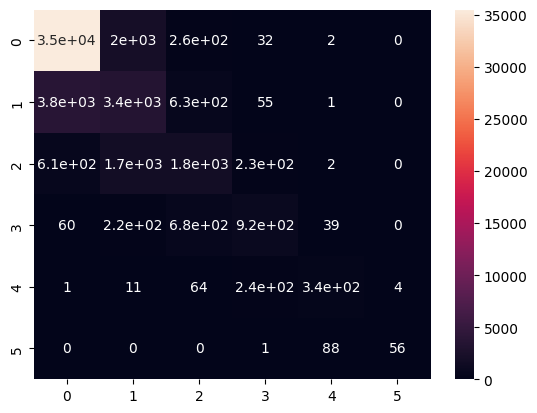

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
import seaborn
seaborn.heatmap(confusion_matrix(df['y_true'].round(), df['y_pred'].round()), annot=True)

In [105]:
# setting data to calculate the ROC AUC
def calculate_metrics(model_name, model_path):

    device=torch.device("cpu")
    print(f"Using device: {device}")
    print(torch.cuda.get_device_name(device=None))

    model = models.HybridModel(num_categorical_features,
                            list_cat,
                            num_numerical_features,
                            num_time_series_features,
                            hidden_size,
                            num_lstm_layers,
                            dropout,
                            embedding_dims,
                            num_fc_tabular_layers,
                            num_fc_combined_layers,
                            output_size=output_weeks,
    )

    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)

    dict_map = {
        "y_pred": [],
        "y_pred_rounded": [],
        "y_true": [],
        "week": [],
    }
    i = 0
    for static, static_cat, x, y in tqdm(
        test_loader,
        desc="Test predictions...",
    ):
        x, static, y = x.to(device), static.to(device), y.to(device)
        with torch.no_grad():
            pred = predict(x, static, static_cat).clone().detach()
        for w in range(output_weeks):
            dict_map["y_pred"] += [float(p[w]) for p in pred]
            dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
            # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
            # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
            dict_map["y_true"] += [float(item[w]) for item in y]
            dict_map["week"] += [w] * len(x)
        i += len(x)
    df = pd.DataFrame(dict_map)

    # for w in range(6):
    #     wdf = df[df['week']==w]
    #     mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    #     f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    #     print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

    y_true_roc = df['y_true'].round()
    y_pred_roc = df['y_pred'].round()
    y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
    for i in range(len(y_pred_roc)):
        y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

    y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
    for i in range(len(y_true_roc)):
        y_true_for_sklearn[i, int(y_true_roc[i])] = 1

    mae = mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
    f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
    roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')
    
    results = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})

    return results

In [27]:
ablation_study_schema = [("static", "models/MH_Hyper/MH_Hyper_12.pt"),
                         ("ts_no_att", "models/MH_Hybrid_manual/MH_Hybrid_manual_oneLoss.pt"),
                         ("ts", ""),
                         ("static_ts_no_att", ""),
                         ("entire", ""),
                         ]

In [106]:
ablation_study_schema = [("static", "models/MH_Hyper/MH_Hyper_12.pt"),
                         ("ts_no_att", "models/MH_Hybrid_manual/MH_Hybrid_manual_oneLoss.pt"),
                         ]

In [107]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'F1', 'ROC_AUC'])

for name, path in ablation_study_schema:
    # Fixing a seed to warrant the reproducibility
    torch.manual_seed(21)
    np.random.seed(21)
    results_df = pd.concat([results_df, calculate_metrics(name, path)])

Using device: cpu
NVIDIA T1000 8GB


Test predictions...: 100%|██████████| 69/69 [00:45<00:00,  1.52it/s]
/tmp/ipykernel_991230/3949740452.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, calculate_metrics(name, path)])


Using device: cpu
NVIDIA T1000 8GB


Test predictions...: 100%|██████████| 69/69 [00:50<00:00,  1.35it/s]


In [108]:
results_df

,Model,MAE,RMSE,F1,ROC_AUC
0,static,0.259719,0.464611,0.576902,0.783225
0,ts_no_att,0.259719,0.464611,0.576902,0.783225
